# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting classifiers

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10_000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = (np.cumsum(coin_tosses, axis=0) 
                              / np.arange(1, 10_001).reshape(-1, 1))

In [3]:
coin_tosses.shape, cumulative_heads_ratio.shape

((10000, 10), (10000, 10))

Saving figure law_of_large_numbers_plot


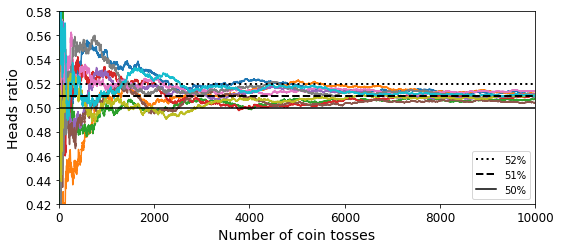

In [4]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10_000], [0.52, 0.52], "k:", linewidth=2, label="52%")
plt.plot([0, 10_000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10_000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10_000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

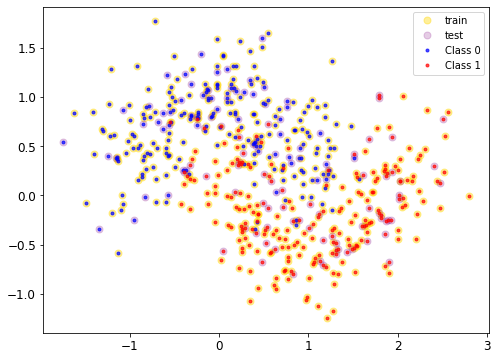

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(X_train[:, 0], X_train[:, 1], 
         'o', color='gold', markersize=7, alpha=0.4, label='train')
plt.plot(X_test[:, 0], X_test[:, 1], 
         'o', color='purple', markersize=7, alpha=0.2, label='test')

plt.plot(X[y==0, 0], X[y==0, 1], 'o', color='blue', 
         markersize=3, alpha=0.7, label='Class 0')
plt.plot(X[y==1, 0], X[y==1, 1], 'o', color='red', 
         markersize=3, alpha=0.7, label='Class 1')
plt.legend();

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


#### Soft voting:

In [10]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft') # different here
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging ensembles

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [14]:
bag_clf.oob_score_

0.9253333333333333

In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [16]:
bag_clf.oob_decision_function_[:5]

array([[0.35849057, 0.64150943],
       [0.43513514, 0.56486486],
       [1.        , 0.        ],
       [0.0128866 , 0.9871134 ],
       [0.03174603, 0.96825397]])

In [17]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], 
                           alpha=0.5, alpha_contour = 0.2, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.2, cmap=custom_cmap)
    
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=alpha_contour)
    plt.plot(X[y==0, 0], X[y==0, 1], "yo", alpha=alpha)
    plt.plot(X[y==1, 0], X[y==1, 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


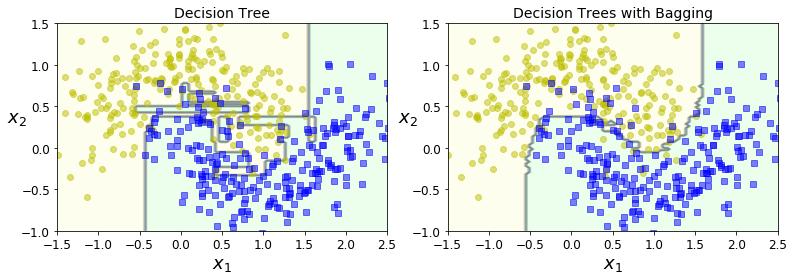

In [18]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

# Random Forests

In [19]:
# Random Subspaces Method
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [20]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [22]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [24]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

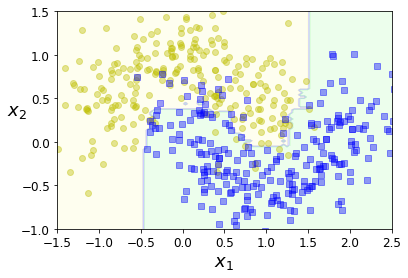

In [25]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X, y)
plot_decision_boundary(rnd_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], 
                       alpha=0.4, contour=False)

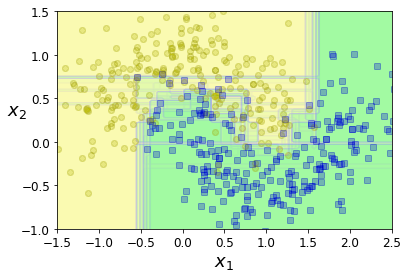

In [26]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

# Feature importance

In [27]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [29]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


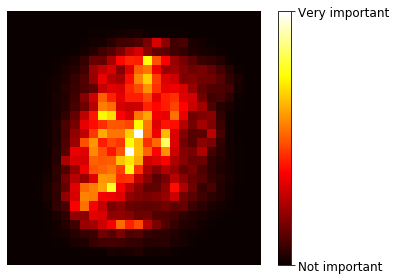

In [30]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# AdaBoost

In [31]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

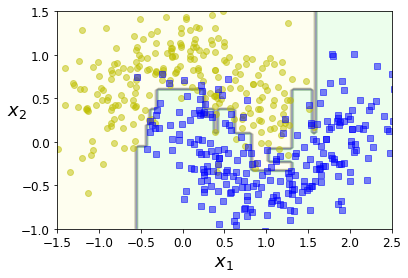

In [32]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


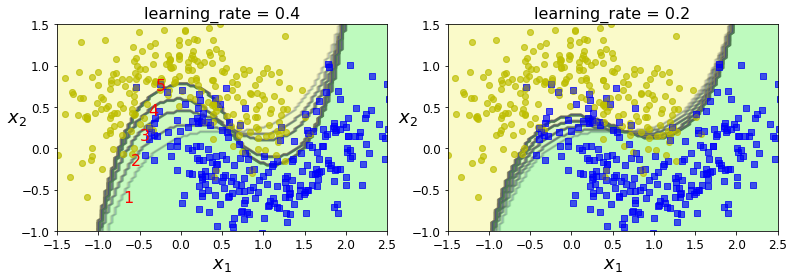

In [33]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 0.4), (122, 0.2)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        
        wrong_sum = sample_weights[y_pred != y_train].sum()
        total = sample_weights.sum()
        r = wrong_sum / total
        weight = learning_rate * np.log((1-r)/r)
        sample_weights[y_pred != y_train] *= np.exp(weight)
#         sample_weights /= np.sum(sample_weights)
        
        plot_decision_boundary(svm_clf, X, y, alpha=0.2, alpha_contour = 0.1 + i*0.16)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", color = 'r', fontsize=16)
        plt.text(-0.6, -0.20, "2", color = 'r', fontsize=16)
        plt.text(-0.5,  0.10, "3", color = 'r', fontsize=16)
        plt.text(-0.4,  0.40, "4", color = 'r', fontsize=16)
        plt.text(-0.3,  0.70, "5", color = 'r', fontsize=16)

save_fig("boosting_plot")
plt.show()

In [34]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting

In [35]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [36]:
X.min(), X.max()

(-0.4944778828763976, 0.4868869366005173)

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [38]:
# pseudo residual
y2 = y - tree_reg1.predict(X)
# build a model on pseudo-residual
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [39]:
# pseudo residual
y3 = y2 - tree_reg2.predict(X)
# build a model on pseudo-residual
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [40]:
X_new = np.array([[0.8]])

In [41]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
# F1(x) + F2(x) + F3(x)
y_pred

array([0.75026781])

In [42]:
def plot_predictions(regressors, X, y, axes, label=None, 
                     style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    # sum(list(3 x 100)) -> array(100,)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors) 
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


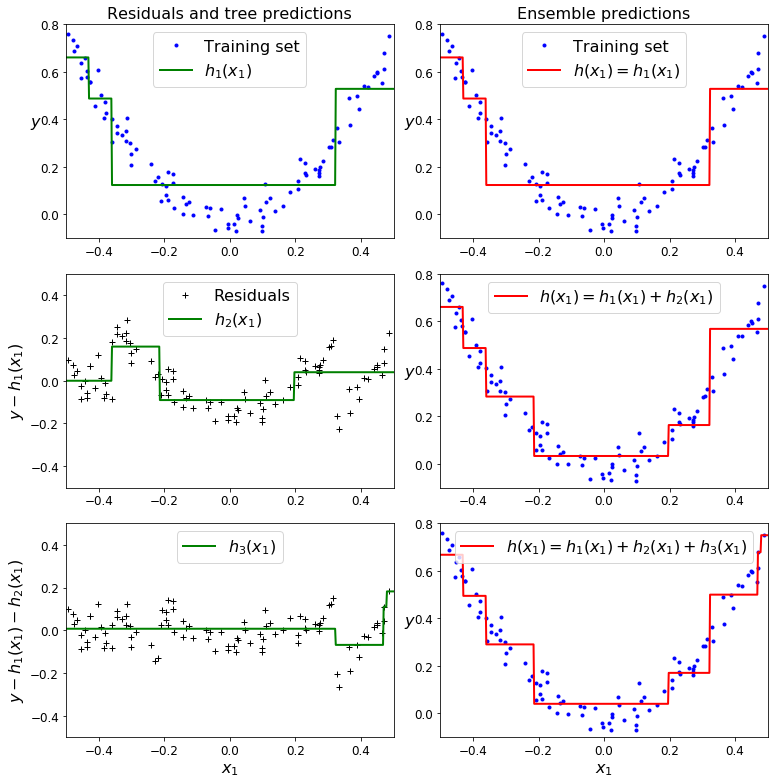

In [43]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [45]:
# Notice the difference is n_estimators
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


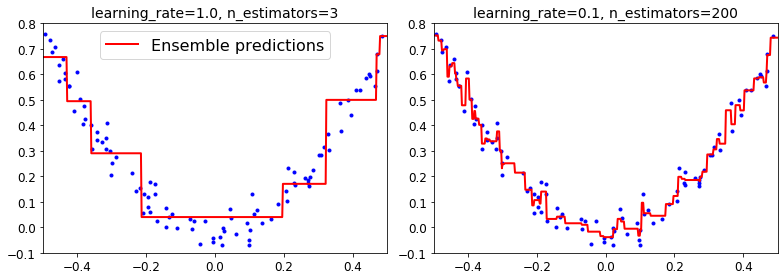

In [46]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# find the best estimator number
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [48]:
min(errors)

0.002712853325235463

Saving figure early_stopping_gbrt_plot


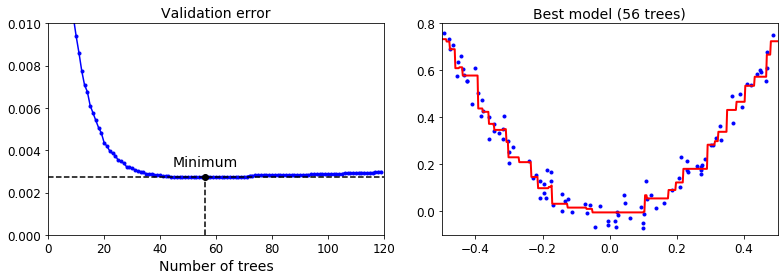

In [49]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title(f"Best model ({bst_n_estimators} trees)", fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting `warm_start=True`.

In [50]:
from sklearn.base import clone

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
best_gbrt = None

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
        best_gbrt = clone(gbrt)
    else:
        error_going_up += 1
        if error_going_up == 5:
            # going back to the best model
            gbrt = clone(best_gbrt).fit(X_train, y_train)
            break  # early stopping

In [51]:
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

56
Minimum validation MSE: 0.002712853325235463


1.64 ms ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


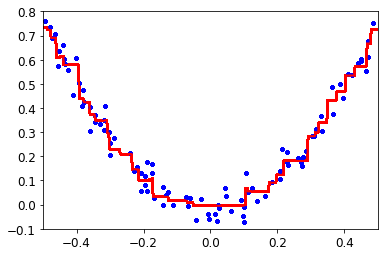

In [52]:
%%timeit
gbrt.fit(X_train, y_train)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

### Stochastic Gradient Boosting with Early Stop

In [53]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, 
                                 subsample=0.33, random_state=42)

min_val_error = float("inf")
error_going_up = 0
best_gbrt = None

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
        best_gbrt = clone(gbrt)
    else:
        error_going_up += 1
        if error_going_up == 5:
            # going back to the best model
            gbrt = clone(best_gbrt).fit(X_train, y_train)
            break  # early stopping

In [54]:
print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

57
Minimum validation MSE: 0.0022700718678363755


1.68 ms ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


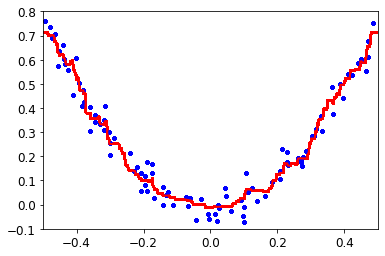

In [55]:
%%timeit
gbrt.fit(X_train, y_train)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

Wow! incorporating randomnness in sampling (using 1/3 of the sample) at each iteration improved performance significantly!

## Using XGBoost

In [56]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [57]:
if xgboost is not None: 
    xgb_reg = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror',)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)           

Validation MSE: 0.0028512559726563943


### Implement with early stopping & subsampling

In [58]:
if xgboost is not None:  
    xgb_reg = xgboost.XGBRegressor(random_state=42, objective='reg:squarederror',
                                  subsample=0.33)
    xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                early_stopping_rounds=5, verbose=5)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)           

[0]	validation_0-rmse:0.28998
Will train until validation_0-rmse hasn't improved in 5 rounds.
[5]	validation_0-rmse:0.183373
[10]	validation_0-rmse:0.120906
[15]	validation_0-rmse:0.087445
[20]	validation_0-rmse:0.063221
[25]	validation_0-rmse:0.049667
[30]	validation_0-rmse:0.046633
[35]	validation_0-rmse:0.043614
[40]	validation_0-rmse:0.043479
Stopping. Best iteration:
[37]	validation_0-rmse:0.042964

Validation MSE: 0.0018459331118246955


6.08 ms ± 65.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


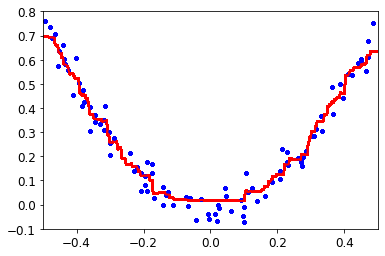

In [59]:
%%timeit
xgb_reg.fit(X_train, y_train)
plot_predictions([xgb_reg], X, y, axes=[-0.5, 0.5, -0.1, 0.8])

# Exercises
## 8. Voting Classifier
>_Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

In [61]:
X_train.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

>Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [62]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [63]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [64]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                 

/Users/soohyeonkim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [65]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.8641, 0.963]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

>Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [66]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

/Users/soohyeonkim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [67]:
voting_clf.score(X_val, y_val)

0.9716

In [68]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.8641, 0.963]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [69]:
# voting_clf.get_params()

In [70]:
voting_clf.set_params(svm_clf=None)

voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=100,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fracti

However, it did not update the list of _trained_ estimators:

In [71]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [72]:
del voting_clf.estimators_[2]

Now let's evaluate the `VotingClassifier` again:

In [73]:
voting_clf.score(X_val, y_val)

0.9741

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [74]:
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)

0.9711

That's barely an improvement, so let us revert to "hard" voting

Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

In [75]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9706

In [76]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9573]

The voting classifier reduced the error rate from about 4.0% for our best model (the `MLPClassifier`) to just 3.0%. That's about 25% less errors, not bad!

## 9. Stacking Ensemble
_Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [77]:
# estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [78]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [79]:
X_val_predictions.shape

(10000, 4)

In [80]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [81]:
rnd_forest_blender.oob_score_

0.969

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [82]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [83]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [84]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.967

This stacking ensemble does not perform as well as the soft voting classifier we trained earlier, it's just as good as the best individual classifier.

-----
Let us streamline the process as below:

In [85]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class Stack_Classifier(BaseEstimator):
    def __init__(self, random_state=42):
        self.random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        self.extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=random_state)
        self.svm_clf = LinearSVC(random_state=random_state)
        self.mlp_clf = MLPClassifier(random_state=random_state)
        self.rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=random_state)

        self.estimators = [self.random_forest_clf, self.extra_trees_clf, 
                            self.svm_clf, self.mlp_clf]
    

    def fit(self, X, y):
        for estimator in self.estimators:
            estimator.fit(X, y)
            
        X_val_predictions = np.empty((len(X), len(self.estimators)), dtype=np.float32)     
        for index, estimator in enumerate(self.estimators):
             X_val_predictions[:, index] = estimator.predict(X)
        self.rnd_forest_blender.fit(X_val_predictions, y)
        
        return self

    def predict(self, X, y=None):
        X_val_predictions = np.empty((len(X), len(self.estimators)), dtype=np.float32)
        for index, estimator in enumerate(self.estimators):
             X_val_predictions[:, index] = estimator.predict(X)
        return self.rnd_forest_blender.predict(X_val_predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [86]:
stack_clf = Stack_Classifier()

In [87]:
stack_clf.fit(X_train, y_train)

/Users/soohyeonkim/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/soohyeonkim/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Stack_Classifier(random_state=None)

In [88]:
stack_clf.score(X_val, y_val)

0.9712

In [89]:
stack_clf.score(X_test, y_test)

0.9651